


\textbf{Frobenius}
exp 5 standard: scores worse lin(ish) in N, flat in num batches????
exp 5 mmd:       scores worse lin(ish) in N, flat in num batches????
exp 6 standard:  no discernible relationship
exp 6 mmd:          better (lin-ish) in batch size, ???? in num batch 
exp 7 standard: lin worse in N, flat in # epochs
exp 7 mmd:      : worse in N (\textbf{replot without epochs =1}), flat in # epochs after ~10
exp 8 standard:  lin in N, flt in VAE size (above scale=1) (\textit{looks nice!}
exp 8 mmd       : lin worse in N, flat/\textbf{ISSUES} in vae layer size
exp 9 standard: \textbf{broken}

\textbf{\textit{rounding issues!!!!!!!}}

\textbf{MMD}
exp 5 standard:     not useful - slight worse in n, mostly flat in #  batches
exp 5 mmd : no change
exp 6 standard:     as exp 5
exp 6 mmd: no use
exp 7 standard: lin in n and # epochs
exp 7 mmd:      \textbf{replot w/o epoch 1}
exp 8 standard: roughly lin in both
exp 8 mmd: \textbf{redo???}  
exp 9 standard: \textbf{broken}

\textbf{Moments diff}
exp 5 standard: flat # batches,  weird in n
exp 5 mmd: \textbf{exclude outliers}
exp 6 standard
exp 6 mmd
exp 7 standard
exp 7 mmd
exp 8 standard
exp 8 mmd

13 standard


In [1]:
%load_ext autoreload
%autoreload 2

# PriorVAE: Comparisons of scaling

In [12]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as onp
from jax import random
from numpyro.infer import Predictive

from plotting.helpers import pretty_label, pretty_loss_fn_name
from plotting.plots import (plot_draws_hpdi, plot_times_graph,
                            plot_times_matrix, plot_training, plot_score_contours)
from reusable.gp import OneDGP
from reusable.util import (gen_file_name, get_decoder_params, load_args,
                           load_scores, load_training_history,
                           load_training_state, update_args_11)
from reusable.vae import VAE, vae_sample

rng_key_gp, rng_key_predict = random.split(random.PRNGKey(2))


plot_gp_predictive = Predictive(OneDGP, num_samples=1000)

In [3]:
def plot_experiment(experiment, count):
    temp_args = load_args("11", count, experiment)


    gp_draws = plot_gp_predictive(rng_key_gp, x=temp_args["x"], gp_kernel=temp_args["gp_kernel"], jitter=1e-5)["y"]

    exp_args = temp_args[experiment]

    aL = len(exp_args["Arange"])
    bL = len(exp_args["Brange"])


    for loss_fn in temp_args["loss_fns"]:
        pretty_lf = pretty_loss_fn_name(loss_fn)

        prettyAdesc = pretty_label(exp_args["Adesc"])
        prettyBdesc = pretty_label(exp_args["Bdesc"])
        

        training_fig, training_axs = plt.subplots(nrows=aL, ncols=bL, figsize=(bL * 6, aL * 5))
        training_fig.suptitle(
            f"{experiment}: row:{prettyAdesc}, col:{prettyBdesc}Test/train for loss fn {pretty_lf}",
            fontsize=40,
        )

        comp_fig, comp_axs = plt.subplots(nrows=aL + 1, ncols=bL, figsize=(bL * 6, aL * 5 + 5))
        comp_fig.suptitle(
            f"{experiment}: row:{prettyAdesc}, col:{prettyBdesc} comparison plots for {pretty_lf}",
            fontsize=40,
        )

        plot_draws_hpdi(gp_draws, temp_args["x"], f"GP draws", "$y=f_{GP}(x)$", "GP", ax=comp_axs[0, 0])

        for j in range(1, len(exp_args["Brange"])):
            comp_axs[0, j].remove()

        for i, a in enumerate(exp_args["Arange"]):
            for j, b in enumerate(exp_args["Brange"]):
                args =  load_args("11", count, experiment)

                args = update_args_11(args, args[experiment], i, j)

                index = i + j * aL
                try:
                    metrics_history = load_training_history("11", gen_file_name("11", args, f"11_{experiment}_{index}_{loss_fn}"))

                    
                    plot_training(
                        metrics_history["test_loss"],
                        metrics_history["train_loss"],
                        f"Test/train loss for {prettyAdesc}={a}, {prettyBdesc}={b}",
                        "loss",
                        training_axs[i, j],
                    )

                    dummy = VAE(
                        hidden_dim1=args["hidden_dim1"],
                        hidden_dim2=args["hidden_dim2"],
                        latent_dim=args["latent_dim"],
                        out_dim=args["n"],
                        conditional=False,
                    )
                    dummy_params = dummy.init(random.PRNGKey(0), jnp.ones((args["latent_dim"],)))

                    decoder_params = get_decoder_params(load_training_state("11", gen_file_name("11", args, f"11_{experiment}_{index}_{loss_fn}"), dummy_params))

                  
                    plot_vae_predictive = Predictive(vae_sample, num_samples=1000)
                    vae_draws = plot_vae_predictive(
                        rng_key_predict,
                        hidden_dim1=args["hidden_dim1"],
                        hidden_dim2=args["hidden_dim2"],
                        latent_dim=args["latent_dim"],
                        out_dim=args["n"],
                        decoder_params=decoder_params,
                    )["f"]

                    plot_draws_hpdi(
                        vae_draws,
                        args["x"],
                        f"{prettyAdesc}={a}, {prettyBdesc}={b}",
                        "$y=f_{VAE}(x)$",
                        "VAE",
                        ax=comp_axs[i + 1, j],
                    )

                except FileNotFoundError:
                    print(f"Failed to load a={a}, b={b}")

        comp_fig.savefig(f"./gen_plots/11/exps/11_{experiment}_{count}_{loss_fn}_draws.pdf")
        training_fig.savefig(f"./gen_plots/11/exps/11_{experiment}_{count}_{loss_fn}_training.pdf")


# Grid of training plots

In [4]:

def plot_experiment_times(experiment, count):
    temp_args = load_args("11", count, experiment)


    exp_args = temp_args[experiment]
    aL = len(exp_args["Arange"])

    for loss_fn in temp_args["loss_fns"]:

        pretty_lf = pretty_loss_fn_name(loss_fn)

        prettyAdesc = pretty_label(exp_args["Adesc"])
        prettyBdesc = pretty_label(exp_args["Bdesc"])

        histories = []


        for i, a in enumerate(exp_args["Arange"]):
            i_hists = []
            for j, b in enumerate(exp_args["Brange"]):
                args =  load_args("11", count, experiment)

                args = update_args_11(args, args[experiment], i, j)

                index = i + j * aL
            

                try:
                    h = load_training_history("11", gen_file_name("11", args, f"11_{experiment}_{index}_{loss_fn}"))
                    
                    i_hists.append(h)

                except FileNotFoundError:
                    i_hists.append({"interrupted": True})
                    print(f"Failed to load a={a}, b={b}")
            histories.append(i_hists)
            
        full_times = onp.array([[h["epoch_times"][-1] if "epoch_times" in h else float('nan') for h in hs] for hs in histories]) / 60
        onp.savetxt(f"./gen_plots/11/11_{experiment}_{loss_fn}_data.csv", full_times)

        interrupted = onp.array([["interrupted" in h for h in hs] for hs in histories])
        full_epochs = onp.array([[len(h["epoch_times"])if "epoch_times" in h else float('nan') for h in hs] for hs in histories])

        masked_times = onp.ma.array(full_times, mask=interrupted)

        # matrix of A x B, showing times
        plot_times_matrix(
            masked_times,
            exp_args["Arange"],
            exp_args["Brange"],
            prettyAdesc,
            prettyBdesc,
            f"{experiment}: {pretty_lf}",
            save_path=f"./gen_plots/11/times/11_{experiment}_{loss_fn}_matrix.png",
        )
        # graph of x=A, y=time, curve per B

        plot_times_graph(
            masked_times,
            exp_args["Brange"],
            exp_args["Arange"],
            prettyBdesc,
            prettyAdesc,
            f"{pretty_lf}",
            save_path=f"./gen_plots/11/times/11_{experiment}_{loss_fn}_timeVb.png",
        )
        # graph of x=B, y=time, curve per B
        plot_times_graph(
            masked_times.T,
            exp_args["Arange"],
            exp_args["Brange"],
            prettyAdesc,
            prettyBdesc,
            f"{pretty_lf}",
            save_path=f"./gen_plots/11/times/11_{experiment}_{loss_fn}_timeVa.png",
        )

        # same graphs, but just increase from initial:
        initial_times = full_times[:, 0][:, jnp.newaxis]
        initial_times = jnp.tile(initial_times, (1, full_times.shape[1]))

        plot_times_graph(
            onp.ma.subtract(masked_times, initial_times),
            exp_args["Brange"],
            exp_args["Arange"],
            prettyBdesc,
            prettyAdesc,
            f"{pretty_lf}",
            is_relative=True,
            save_path=f"./gen_plots/11/times/11_{experiment}_{loss_fn}_timeVb_change.png",
        )

        initial_times = full_times.T[:, 0][:, jnp.newaxis]
        initial_times = jnp.tile(initial_times, (1, full_times.shape[0]))
        # graph of x=B, y=time, curve per B
        plot_times_graph(
            onp.ma.subtract(masked_times.T, initial_times),
            exp_args["Arange"],
            exp_args["Brange"],
            prettyAdesc,
            prettyBdesc,
            f"{pretty_lf}",
            is_relative=True,
            save_path=f"./gen_plots/11/times/11_{experiment}_{loss_fn}_timeVa_change.png",
        )


In [ ]:
plot_experiment_times("exp5", "1")
plot_experiment_times("exp6", "1")
plot_experiment_times("exp7", "1")
plot_experiment_times("exp8", "1")
plot_experiment_times("exp9", "1")

In [ ]:
plot_experiment("exp5", "1")

In [ ]:
plot_experiment("exp6", "1")

In [ ]:
plot_experiment("exp7", "1")

In [ ]:
plot_experiment("exp8", "1")

In [ ]:
plot_experiment("exp9", "1")

In [35]:
from plotting.plots import plot_scores_graph

def plot_experiment_scores(experiment, count, outlier_bounds = None, plot_ranges= None):
    temp_args = load_args("11", count, experiment)

    exp_args = temp_args[experiment]
    aL = len(exp_args["Arange"])


    prettyAdesc = pretty_label(exp_args["Adesc"])
    prettyBdesc = pretty_label(exp_args["Bdesc"])
    Adesc = exp_args["Adesc"]
    Bdesc = exp_args["Bdesc"]

    for loss_fn in temp_args["loss_fns"]:
        pretty_lf = pretty_loss_fn_name(loss_fn)


        scores = []

        for i, a in enumerate(exp_args["Arange"]):
            ss = []
            for j, b in enumerate(exp_args["Brange"]):
                args = load_args("11", count, experiment)

                args = update_args_11(args, args[experiment], i, j)

                index = i + j * aL

                try:
                    s = load_scores("11", gen_file_name("11", args, f"11_{experiment}_{index}_{loss_fn}", "B"))
                    new_s = {
                        "frobenius": jnp.mean(jnp.array(s["frobenius"])),
                        "moments_diff": jnp.mean(
                            jnp.abs(jnp.mean(jnp.array(s["vae_moments"]) - jnp.array(s["gp_moments"]), axis=1))
                        ),
                        "mmd": jnp.sum(jnp.array([x[1] for x in s["mmd"]])),
                    }

                

                    ss.append(new_s)

                except FileNotFoundError:
                    ss.append({"frobenius": onp.nan, "moments_diff": onp.nan, "mmd": onp.nan, "interrupted": True})
                    print(f"Failed to load a={a}, b={b}")
            scores.append(ss)

        to_plot =  ["frobenius", "moments_diff", "mmd"]
        nice_labels = ["Mean Frobenius norm", "Mean moments difference", "Mean MMD score"]
        
        interrupted = onp.array([["interrupted" in cell for cell in row] for row in scores])
        scores = [onp.array([[cell[t] for cell in row] for row in scores])  for t in to_plot]

        for i,t in enumerate(to_plot):
            masked_scores = onp.ma.array(scores[i], mask=interrupted)
            # plot_times_matrix(
            #     masked_scores,
            #     exp_args["Arange"],
            #     exp_args["Brange"],
            #     prettyAdesc,
            #     prettyBdesc,
            #     f"{experiment}: {pretty_lf}, {t}",
            #     save_path=f"./gen_plots/11/scores/11_{experiment}_{loss_fn}_{t}_matrix.png",
            #     upper_limit=outlier_bounds[i] if outlier_bounds is not None else None
            # )


              # graph of x=A, y=time, curve per B

            plot_scores_graph(
                masked_scores,
                exp_args["Brange"],
                exp_args["Arange"],
                prettyBdesc,
                nice_labels[i],
                prettyAdesc,
                f"{pretty_lf}",
                save_path=f"./gen_plots/11/scores/11_{experiment}_{loss_fn}_{t}_score_V_{Bdesc}.png",
                num_decimals=4 if t == "mmd" else 0,
                plot_range=plot_ranges[i] if plot_ranges is not None else None
            )
            # graph of x=B, y=time, curve per B
            plot_scores_graph(
                masked_scores.T,
                exp_args["Arange"],
                exp_args["Brange"],
                prettyAdesc,
                nice_labels[i],
                prettyBdesc,
                f"{pretty_lf}",
                save_path=f"./gen_plots/11/scores/11_{experiment}_{loss_fn}_{t}_score_V_{Adesc}.png",
                num_decimals=4 if t == "mmd" else 0,
                plot_range=plot_ranges[i] if plot_ranges is not None else None
            )


            # plot_score_contours(
            #     masked_scores,
            #     exp_args["Arange"],
            #     exp_args["Brange"],
            #     prettyAdesc,
            #     prettyBdesc,
            #     f"{experiment}: {pretty_lf}, {t}",
            #     save_path=f"./gen_plots/11/scores/11_{experiment}_{loss_fn}_{t}_contours.png",
            #     upper_limit=outlier_bounds[i] if outlier_bounds is not None else None
            # )

        


/home/max/mambaforge/envs/jax_numpyro_env/lib/python3.10/site-packages/numpy/lib/function_base.py:4737: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  arr.partition(


$\mathrm{RCL}+\mathrm{KLD}$ scaling of VAE layer size [0, 93.7074737548828]
$\mathrm{RCL}+\mathrm{KLD}$ $n$ [0, 93.7074737548828]
$\mathrm{RCL}+\mathrm{KLD}$ scaling of VAE layer size [0, 34.26359481811523]
$\mathrm{RCL}+\mathrm{KLD}$ $n$ [0, 34.26359481811523]
$\mathrm{RCL}+\mathrm{KLD}$ scaling of VAE layer size [0, 3.3261743545532227]
$\mathrm{RCL}+\mathrm{KLD}$ $n$ [0, 3.3261743545532227]
$0.01\mathrm{RCL}+\mathrm{KLD}+10\mathrm{MMD}_\mathrm{rbf}(4)$ scaling of VAE layer size [0, 57.32021484375]
$0.01\mathrm{RCL}+\mathrm{KLD}+10\mathrm{MMD}_\mathrm{rbf}(4)$ $n$ [0, 57.32021484375]
$0.01\mathrm{RCL}+\mathrm{KLD}+10\mathrm{MMD}_\mathrm{rbf}(4)$ scaling of VAE layer size [0, 27.894233322143553]
$0.01\mathrm{RCL}+\mathrm{KLD}+10\mathrm{MMD}_\mathrm{rbf}(4)$ $n$ [0, 27.894233322143553]
$0.01\mathrm{RCL}+\mathrm{KLD}+10\mathrm{MMD}_\mathrm{rbf}(4)$ scaling of VAE layer size [0, 0.025595116093754765]
$0.01\mathrm{RCL}+\mathrm{KLD}+10\mathrm{MMD}_\mathrm{rbf}(4)$ $n$ [0, 0.0255951160937547

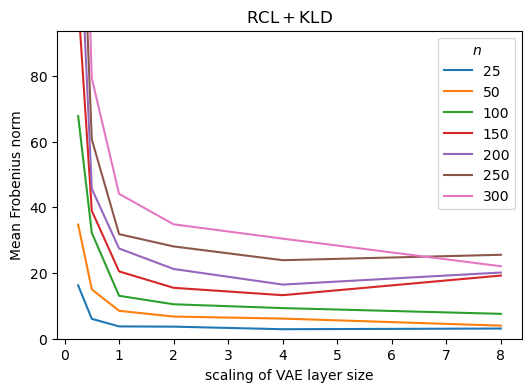

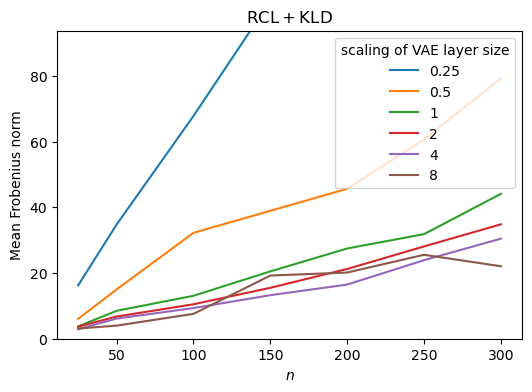

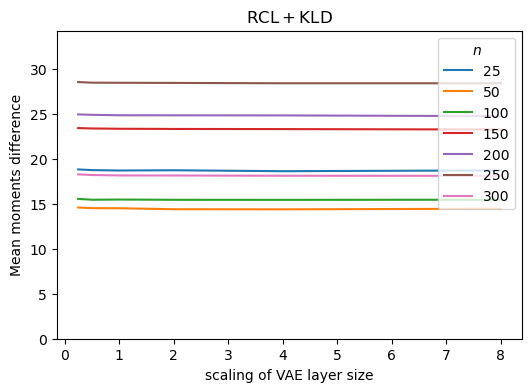

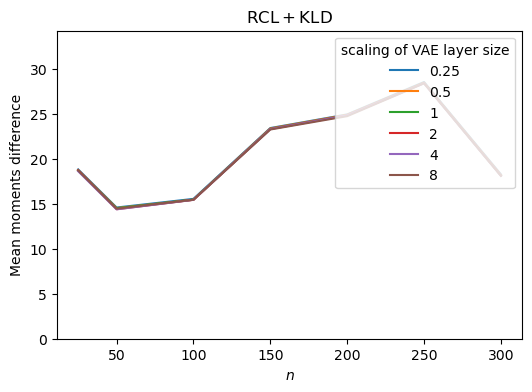

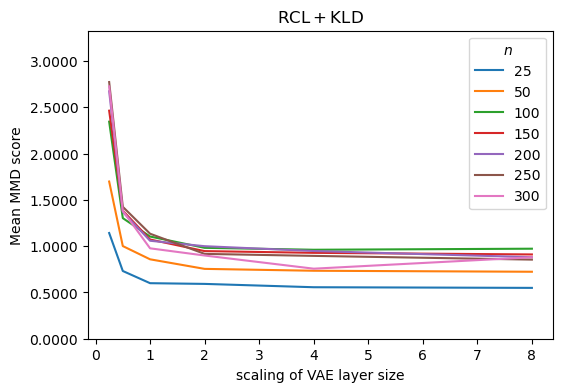

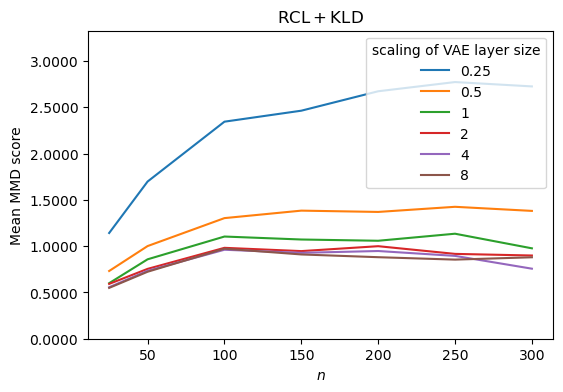

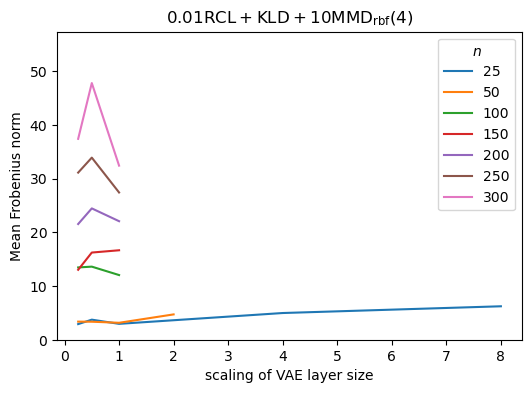

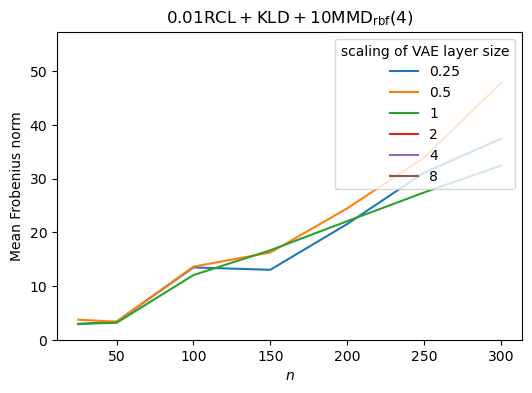

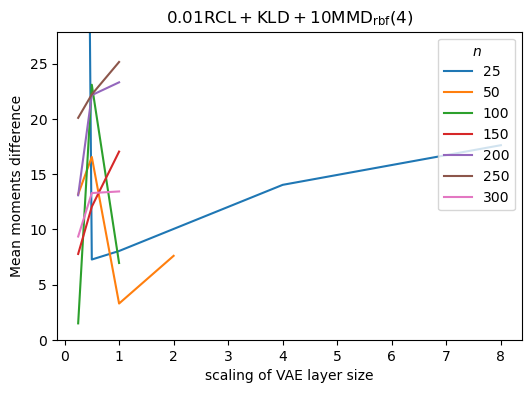

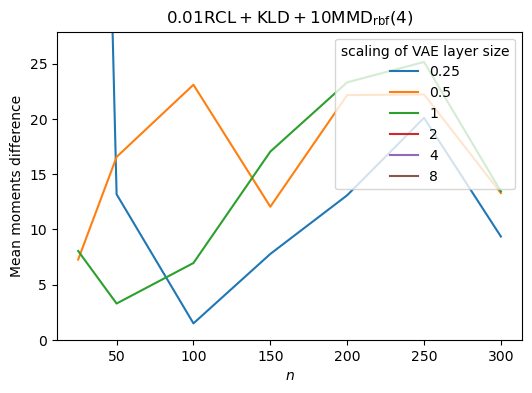

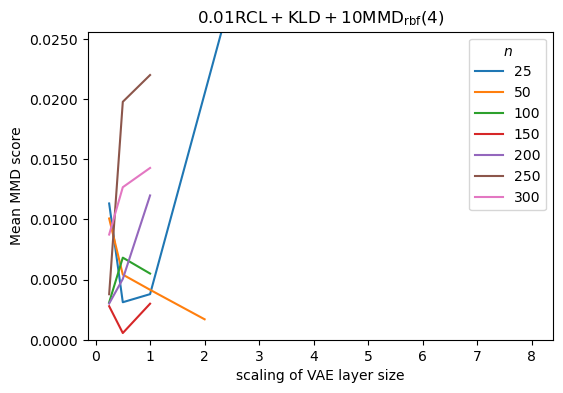

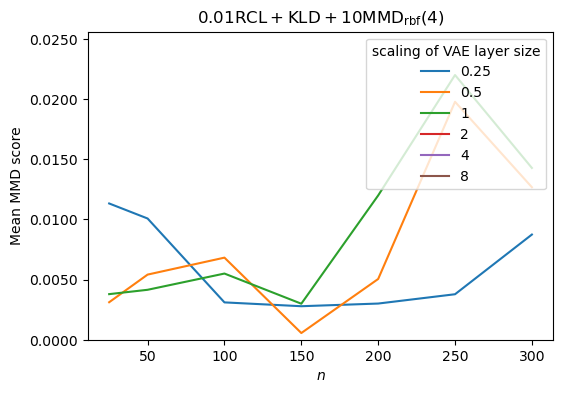

In [39]:
#plot_experiment_scores("exp5", "1")
# plot_experiment_scores("exp6", "1")
#plot_experiment_scores("exp7", "1", plot_ranges=[[0,75], [0, 50], [0,2]])
plot_experiment_scores("exp8", "1")
# plot_experiment_scores("exp9", "1")